In [1]:
from pyspark.sql import SparkSession
import os
from search import Search
from plotting import Plotting

os.environ["PYTHONUNBUFFERED"] = "1"
# os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
# os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"

E:\Users\Sam\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
E:\Users\Sam\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
E:\Users\Sam\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
E:\Users\Sam\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
dataset_dir = 'ml-latest-small'

In [3]:
def read(spark):
    datasets = {}
    for dataset in os.listdir(dataset_dir):
        data = spark.read.option("header", True).format("csv").load(os.path.join(os.getcwd(),dataset_dir,dataset))
        datasets[dataset.split('.')[0]]=data
    return datasets

In [4]:
spark = SparkSession.builder.master("local").appName("Movies").config("conf-key", "conf-value").getOrCreate()
datasets = read(spark)

In [5]:
search = Search(datasets, spark)
plotting = Plotting(search)

Cache the tables for user and movie Ids that will be used frequently

In [6]:
search.cache_user('1')
search.cache_movie('1')
search.cache_movie_string('1995')

Search user by id, show the number of movies/genre that he/she has watched. This also caches the collected dataframe.

In [8]:
import datetime
start = datetime.datetime.now()
search.search_user_movies('1').show()
uncached_time = datetime.datetime.now()-start

+------+-------+------+-------------------+-------+--------------------+--------------------+
|userId|movieId|rating|          timestamp|movieId|               title|              genres|
+------+-------+------+-------------------+-------+--------------------+--------------------+
|     1|      1|   4.0|2000-07-30 19:45:03|      1|    Toy Story (1995)|Adventure|Animati...|
|     1|      3|   4.0|2000-07-30 19:20:47|      3|Grumpier Old Men ...|      Comedy|Romance|
|     1|      6|   4.0|2000-07-30 19:37:04|      6|         Heat (1995)|Action|Crime|Thri...|
|     1|     47|   5.0|2000-07-30 20:03:35|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     1|     50|   5.0|2000-07-30 19:48:51|     50|Usual Suspects, T...|Crime|Mystery|Thr...|
|     1|     70|   3.0|2000-07-30 19:40:00|     70|From Dusk Till Da...|Action|Comedy|Hor...|
|     1|    101|   5.0|2000-07-30 19:14:28|    101|Bottle Rocket (1996)|Adventure|Comedy|...|
|     1|    110|   4.0|2000-07-30 19:36:16|    110|   Braveh

A demonstration that after the dataframe for the user is cached the query runs faster

In [9]:
start = datetime.datetime.now()
search.search_user_movies('1').show()
cached_time = datetime.datetime.now()-start
print('uncached speed: '+str(uncached_time))
print('cached speed: '+str(cached_time))

+------+-------+------+-------------------+-------+--------------------+--------------------+
|userId|movieId|rating|          timestamp|movieId|               title|              genres|
+------+-------+------+-------------------+-------+--------------------+--------------------+
|     1|      1|   4.0|2000-07-30 19:45:03|      1|    Toy Story (1995)|Adventure|Animati...|
|     1|      3|   4.0|2000-07-30 19:20:47|      3|Grumpier Old Men ...|      Comedy|Romance|
|     1|      6|   4.0|2000-07-30 19:37:04|      6|         Heat (1995)|Action|Crime|Thri...|
|     1|     47|   5.0|2000-07-30 20:03:35|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     1|     50|   5.0|2000-07-30 19:48:51|     50|Usual Suspects, T...|Crime|Mystery|Thr...|
|     1|     70|   3.0|2000-07-30 19:40:00|     70|From Dusk Till Da...|Action|Comedy|Hor...|
|     1|    101|   5.0|2000-07-30 19:14:28|    101|Bottle Rocket (1996)|Adventure|Comedy|...|
|     1|    110|   4.0|2000-07-30 19:36:16|    110|   Braveh

In [11]:
search.search_user_genre('1').show()

+---------+------------------+-------+
|   genres|       avg(rating)|watches|
+---------+------------------+-------+
|    Crime| 4.355555555555555|     45|
|  Romance|4.3076923076923075|     26|
| Thriller|4.1454545454545455|     55|
|Adventure|4.3882352941176475|     85|
|    Drama| 4.529411764705882|     68|
|      War|               4.5|     22|
|  Fantasy| 4.297872340425532|     47|
|  Mystery| 4.166666666666667|     18|
|  Musical| 4.681818181818182|     22|
|Animation| 4.689655172413793|     29|
|Film-Noir|               5.0|      1|
|   Horror|3.4705882352941178|     17|
|  Western| 4.285714285714286|      7|
|   Comedy|  4.27710843373494|     83|
| Children|4.5476190476190474|     42|
|   Action| 4.322222222222222|     90|
|   Sci-Fi|             4.225|     40|
+---------+------------------+-------+



Given a list of users, search all movies watched by each user

In [12]:
[i.show() for i in search.search_users_movies(["1","2","3"])]

+------+-------+------+---------+-------+--------------------+--------------------+
|userId|movieId|rating|timestamp|movieId|               title|              genres|
+------+-------+------+---------+-------+--------------------+--------------------+
|     1|      1|   4.0|964982703|      1|    Toy Story (1995)|Adventure|Animati...|
|     1|      3|   4.0|964981247|      3|Grumpier Old Men ...|      Comedy|Romance|
|     1|      6|   4.0|964982224|      6|         Heat (1995)|Action|Crime|Thri...|
|     1|     47|   5.0|964983815|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     1|     50|   5.0|964982931|     50|Usual Suspects, T...|Crime|Mystery|Thr...|
|     1|     70|   3.0|964982400|     70|From Dusk Till Da...|Action|Comedy|Hor...|
|     1|    101|   5.0|964980868|    101|Bottle Rocket (1996)|Adventure|Comedy|...|
|     1|    110|   4.0|964982176|    110|   Braveheart (1995)|    Action|Drama|War|
|     1|    151|   5.0|964984041|    151|      Rob Roy (1995)|Action|Drama|R

[None, None, None]

Given a list of users, show the genre statistics for each user

In [ ]:
[i.show() for i in search.search_users_genres(["1","2","3"])]

Search movie by id/title, show the average rating, the number of users that have watched the movie. Due to caching searching by ID runs faster the second time. This is not possible when searching by name as it may return more than one result.

In [17]:
search.search_movie(id="2").show()

+-------+-----------------+--------+--------------+
|movieId|      avg(rating)|count(1)|         title|
+-------+-----------------+--------+--------------+
|      2|3.246582912721512|   27143|Jumanji (1995)|
+-------+-----------------+--------+--------------+

cached speed: 0:00:01.527202


In [11]:
search.search_movie(name="Toy Story").show()

+-------+-----------------+--------+--------------------+
|movieId|      avg(rating)|count(1)|               title|
+-------+-----------------+--------+--------------------+
| 179401|3.570336391437309|     981|Jumanji: Welcome ...|
|      2|3.246582912721512|   27143|      Jumanji (1995)|
+-------+-----------------+--------+--------------------+

cached speed: 0:00:41.439315


Search genre, show all movies in that genre

In [10]:
search.search_genre("Action").show(10,False)

+-------+-----------------------------------------+----------------------------------+
|movieId|title                                    |genres                            |
+-------+-----------------------------------------+----------------------------------+
|6      |Heat (1995)                              |Action|Crime|Thriller             |
|9      |Sudden Death (1995)                      |Action                            |
|10     |GoldenEye (1995)                         |Action|Adventure|Thriller         |
|15     |Cutthroat Island (1995)                  |Action|Adventure|Romance          |
|20     |Money Train (1995)                       |Action|Comedy|Crime|Drama|Thriller|
|23     |Assassins (1995)                         |Action|Crime|Thriller             |
|42     |Dead Presidents (1995)                   |Action|Crime|Drama                |
|44     |Mortal Kombat (1995)                     |Action|Adventure|Fantasy          |
|66     |Lawnmower Man 2: Beyond Cyberspace

Given a list of genres, search all movies belonging to each genre

In [11]:
[i.show(3, False) for i in search.search_genres(["Action","Romance"])]
# search.search_genres(["Action","Romance"]).show()

+-------+-------------------+-------------------------+
|movieId|title              |genres                   |
+-------+-------------------+-------------------------+
|6      |Heat (1995)        |Action|Crime|Thriller    |
|9      |Sudden Death (1995)|Action                   |
|10     |GoldenEye (1995)   |Action|Adventure|Thriller|
+-------+-------------------+-------------------------+
only showing top 3 rows

+-------+------------------------+--------------------+
|movieId|title                   |genres              |
+-------+------------------------+--------------------+
|3      |Grumpier Old Men (1995) |Comedy|Romance      |
|4      |Waiting to Exhale (1995)|Comedy|Drama|Romance|
|7      |Sabrina (1995)          |Comedy|Romance      |
+-------+------------------------+--------------------+
only showing top 3 rows



[None, None]

Search movies by year

In [8]:
search.search_movie_year("1995").show(10,False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

List the top n movies with highest rating, ordered by the rating

In [13]:
search.list_rating(5)

,movieId,avg(rating),watches,movieId,title,genres
0,53,5.0,2,53,Lamerica (1994),Adventure|Drama
1,78836,5.0,2,78836,Enter the Void (2009),Drama
2,3473,5.0,2,3473,Jonah Who Will Be 25 in the Year 2000 (Jonas q...,Comedy
3,99,5.0,2,99,Heidi Fleiss: Hollywood Madam (1995),Documentary
4,6442,5.0,2,6442,Belle époque (1992),Comedy|Romance


List the top n movies with the highest number of watches, ordered by the number of
watches

In [14]:
search.list_watches(5)

,movieId,watches,movieId,title,genres
0,356,329,356,Forrest Gump (1994),Comedy|Drama|Romance|War
1,318,317,318,"Shawshank Redemption, The (1994)",Crime|Drama
2,296,307,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,279,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,278,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller


Find the favourite genre of a given user, or group of users. Consider and justify how
you will define ‘favourite’.

In [14]:
search.search_user_favourites("1").show(10,False)

+---------+------------------+-------+---+---+------------------+
|genres   |avg(rating)       |watches|max|min|score             |
+---------+------------------+-------+---+---+------------------+
|Comedy   |3.75              |6      |7  |1  |3.125             |
|Drama    |3.6666666666666665|6      |7  |1  |3.0555555555555554|
|Thriller |2.642857142857143 |7      |7  |1  |2.642857142857143 |
|Sci-Fi   |2.75              |6      |7  |1  |2.291666666666667 |
|Action   |2.875             |4      |7  |1  |1.4375            |
|Romance  |4.0               |2      |7  |1  |0.6666666666666666|
|Crime    |3.0               |2      |7  |1  |0.5               |
|Horror   |2.25              |2      |7  |1  |0.375             |
|Adventure|1.5               |1      |7  |1  |0.0               |
|Western  |4.0               |1      |7  |1  |0.0               |
+---------+------------------+-------+---+---+------------------+
only showing top 10 rows



Compare the movie tastes of two users. Consider and justify how you will compare
and present the data.

In [7]:
search.compare_users("1", "2").show()

search.compare_users("477", "610").show()

search.compare_users("1", "1").show()

+------------------+
|        similarity|
+------------------+
|0.0689655172413793|
+------------------+

+-------------------+
|         similarity|
+-------------------+
|0.18584186905960595|
+-------------------+

+----------+
|similarity|
+----------+
|       1.0|
+----------+



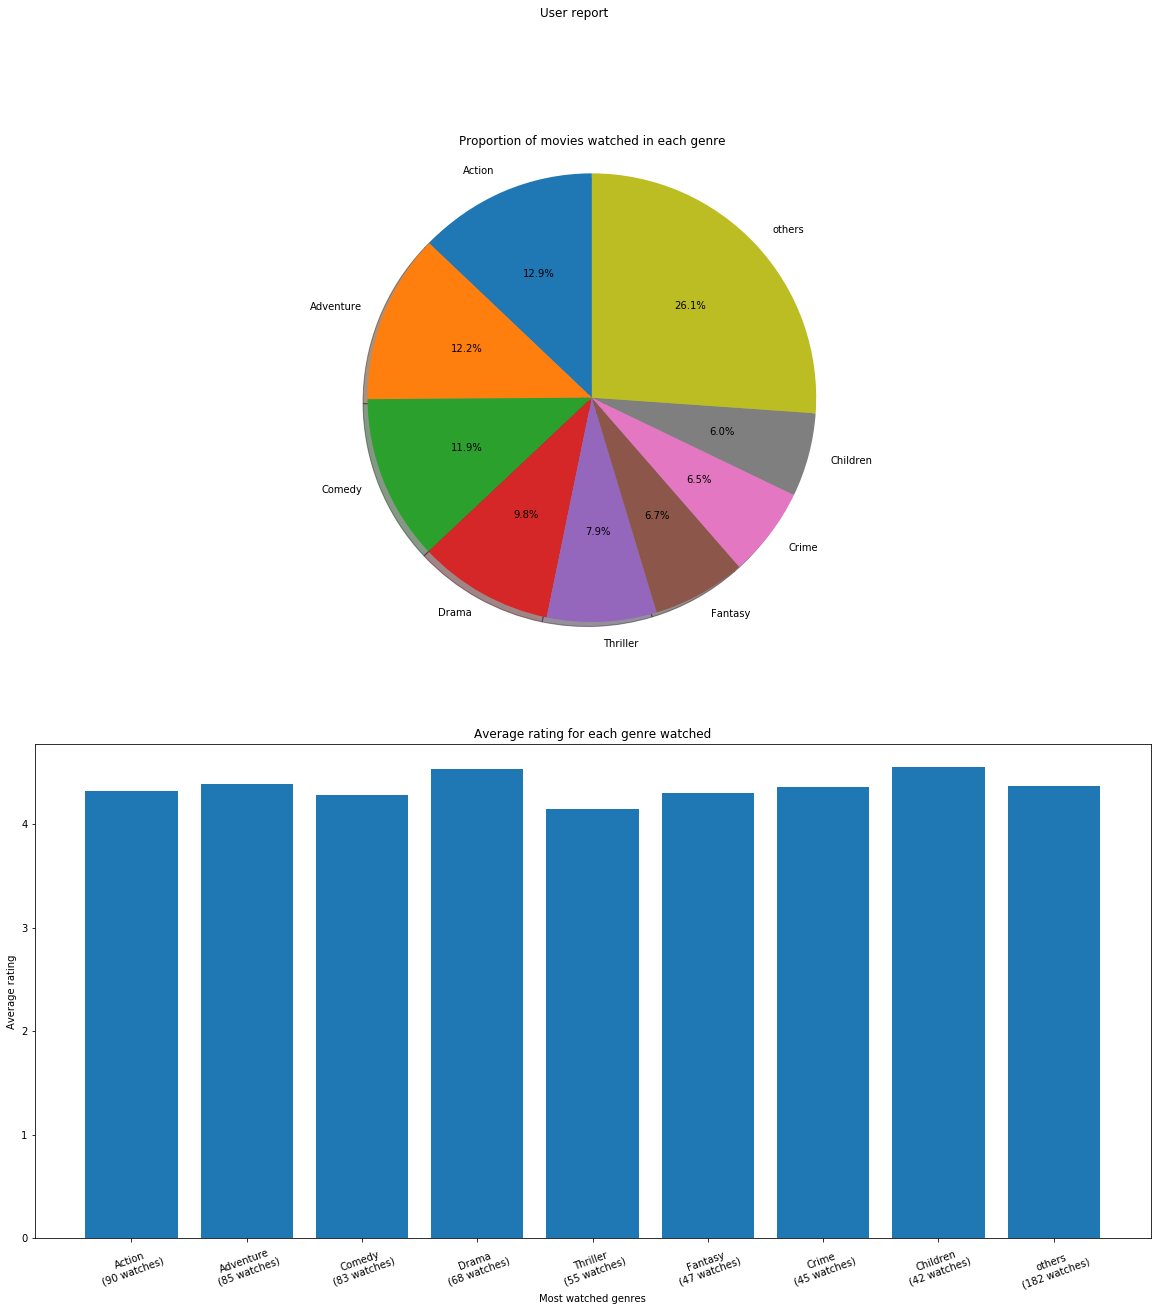

In [7]:
plotting.gen_user_report("1")

Plot the most watched movies in a given year

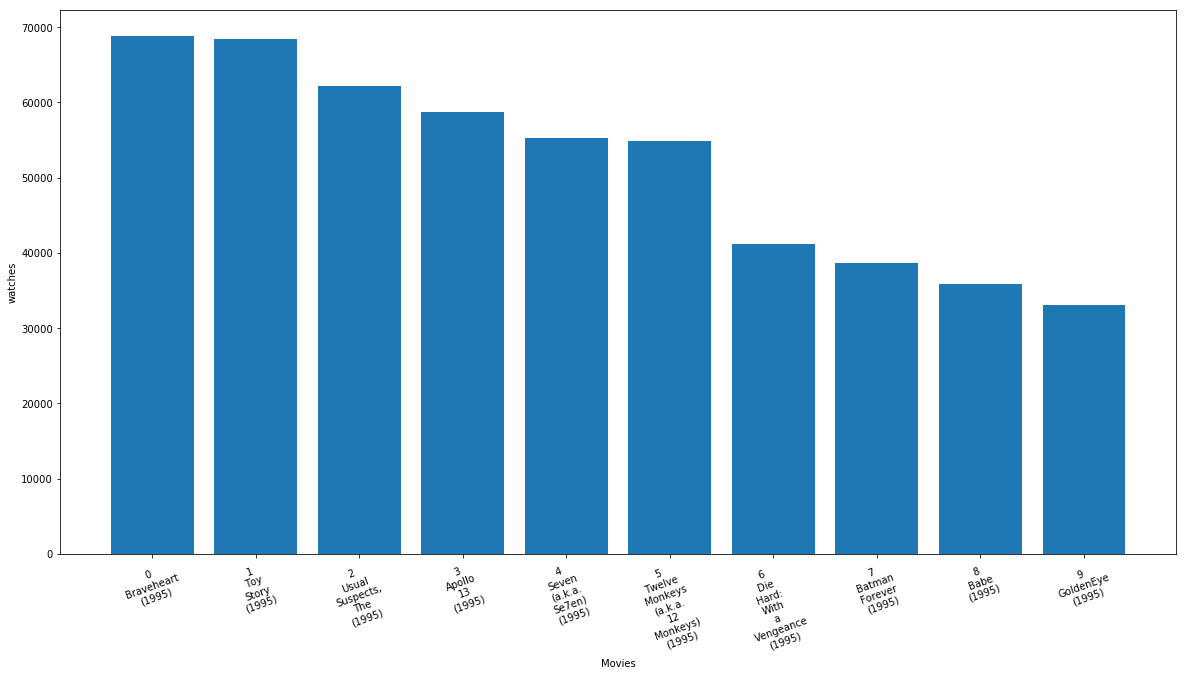

In [9]:
plotting.generic_plot(search.filter_year("1995", 10,"watches"), 'watches')

Plot the most watched movies in a given decade

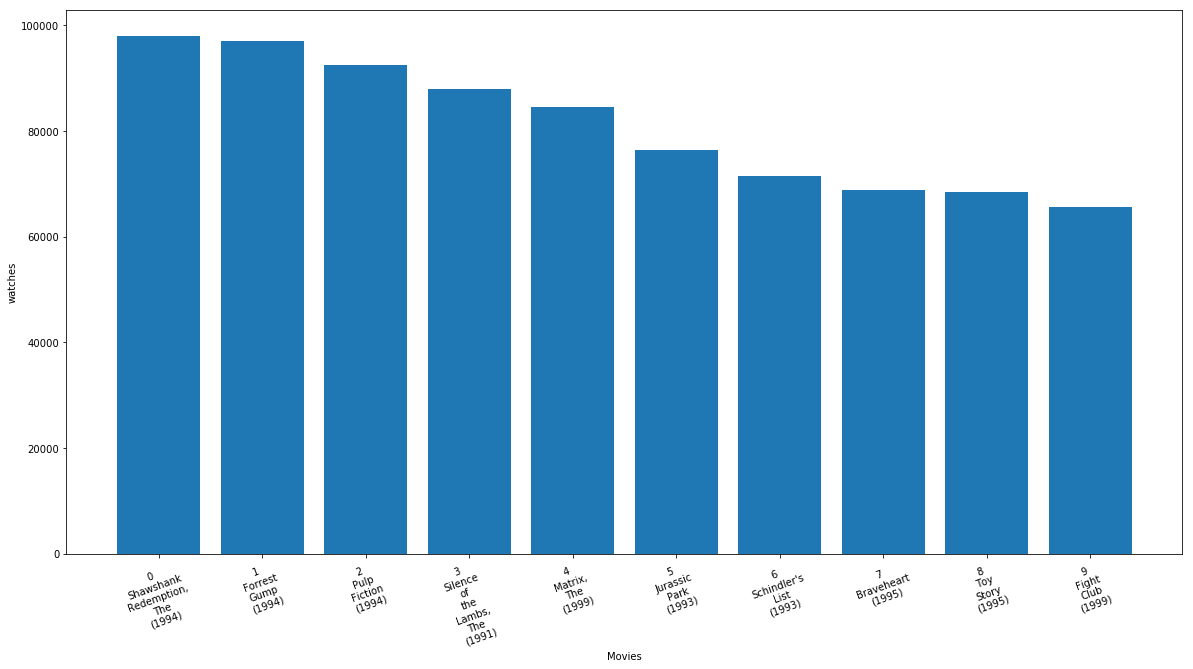

In [11]:
plotting.generic_plot(search.filter_decade("199", 10,"watches"), 'watches')

Plot the most watched movies of each decade. WARNING, VERY SLOW

In [ ]:
plotting.generic_plot(search.top_each_decade('watches'), 'watches')

Plot the most watched movies of all time

In [ ]:
plotting.generic_plot(search.list_watches(10), 'watches')

Plot the highest rated movies in a given year

In [ ]:
plotting.generic_plot(search.filter_year("1995", 10,"avg(rating)"),'avg(rating)')

Plot the highest rated movies in a given decade

In [ ]:
plotting.generic_plot(search.filter_decade("199", 10,"avg(rating)"),'avg(rating)')

Plot the highest rated movies of each decade

In [ ]:
plotting.generic_plot(search.top_each_decade('avg(rating)'),'avg(rating)')

Plot the highest rated movies of all time

In [ ]:
plotting.generic_plot(search.list_rating(10),'avg(rating)')

In [ ]:
plotting.gen_movie_wordcloud("Pulp Fiction")

Recommend movies for a set of users

In [ ]:
search.recommend_n_movies_for_users(5, ["1", "3", "47", "235"]).show(truncate=False)

In [ ]:
search.recommend_n_movies_for_users(5, ["1"]).show(truncate=False)


In [6]:
search.cluster("477", 2)

609


TypeError: '<' not supported between instances of 'NoneType' and 'float'